# Loading and visualizing groundwater models

This exercise, we will load an existing model into Flopy, run the model and then use [pandas](https://pandas.pydata.org/), [matplotlib](https://matplotlib.org/) and [numpy](https://www.numpy.org/) to look at the results and compare them to observed data. We will also export model input and output to shapefiles and rasters.

#### Required executables
* MODFLOW-6; available here: https://github.com/MODFLOW-USGS/executables

#### Operations
* reading tabular data from a file or url using the powerful [`pandas.read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) method
* getting `pandas.DataFrame`s of Hydmod, SFR, and global mass balance output
* converting model times to real date-times to allow plotting against other temporally-referenced data
* getting and plotting MODFLOW observation information
* quickly subsetting data by category, attribute values, times, index position, etc.
* making plots using `matplotlib` and the built-in hooks to it in `pandas`

#### The Pleasant Lake example
The example model is a simplified version of the MODFLOW-6 model published by Fienen et al (2022, 2021; Figure 1), who used a multi-scale modeling approach to evaluate the effects of agricultural groundwater abstraction on the ecology of Pleasant Lake in central Wisconsin, USA. The original report and model files are available at the links below.

Example model details
* Transient MODFLOW-6 simulation with monthly stress periods for calendar year 2012
* units of meters and days
* 4 layers; 200 meter uniform grid spacing
    * layers 1-3 represent surficial deposits
    * layer 4 represents Paleozoic bedrock (sandstone)
* Transient specified head perimeter boundary (CHD package) from a regional model solution
* Recharge specified with RCHA
* Streams specified with SFR
* Pleasant Lake simulated with the Lake Package
* Head observations specified with the OBS utility

In [44]:
from pathlib import Path
import flopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [45]:
# make an output folder
output_folder = Path('03-output')
output_folder.mkdir(exist_ok=True)

### load a preexisting MODFLOW 6 model
Because this is MODFLOW 6, we need to load the simulation first, and then get the model.

**Note:** To avoid loading certain packages (that may be too slow) use the ``load_only`` argument to specify the packages that should be loaded.   
e.g. ``load_only=['dis']``

In [46]:
%%capture
sim_ws = Path('data/pleasant-lake/')
sim = flopy.mf6.MFSimulation.load('pleasant', sim_ws=str(sim_ws), exe_name='mf6',
                                  #load_only=['dis']
                         )
sim.model_names

In [47]:
m = sim.get_model('pleasant')

## Visualizing the model

First let's check that the model grid is correctly located. It is, in this case, because the model has the origin and rotation specified in the DIS package.

In [48]:
m.modelgrid

xll:552400.0; yll:387200.0; rotation:0.0; units:meters; lenuni:2

In [49]:
m.get_package_list()

['DIS',
 'IC',
 'NPF',
 'STO',
 'RCHA_0',
 'OC',
 'CHD_OBS',
 'CHD_0',
 'SFR_OBS',
 'SFR_0',
 'LAK_OBS',
 'LAK_LAKTAB',
 'LAK_0',
 'WEL_0',
 'OBS_3']

However, in order to write shapefiles with a ``.prj`` file that specifies the coordinate references system (CRS), we need to assign one to the grid (there currently is no CRS input for MODFLOW 6). We can do this by simply specifying an [EPSG code](https://epsg.io/) to the ``crs`` attribute (in this case 3070 for Wisconsin Transverse Mercator).

In [50]:
m.modelgrid.crs = 3070

### On a map
We can plot the model in the CRS using the ``PlotMapView`` object. More examples in the Flopy demo here (for unstructured grids too!): https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3.3_PlotMapView.ipynb

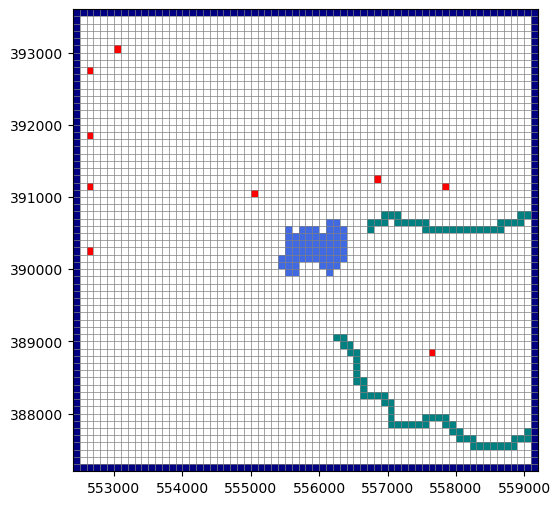

In [51]:
fig, ax = plt.subplots(figsize=(6, 6))
pmv = flopy.plot.PlotMapView(m, ax=ax)
lc = pmv.plot_grid(lw=0.5)
pmv.plot_bc("WEL", plotAll=True)
pmv.plot_bc("LAK", plotAll=True)
pmv.plot_bc("SFR", plotAll=True)
pmv.plot_bc("CHD", plotAll=True)


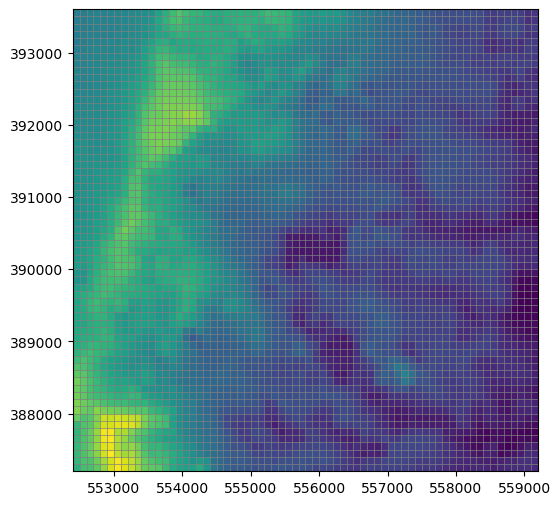

In [52]:
fig, ax = plt.subplots(figsize=(6, 6))
pmv = flopy.plot.PlotMapView(m, ax=ax)
lc = pmv.plot_grid(lw=0.5)
top = pmv.plot_array(m.dis.top.array)

### Exporting the model grid to a shapefile

In [53]:
m.modelgrid.write_shapefile(str(output_folder / 'pleasant_grid.shp'))

### Making a cross section through the model

more examples in the Flopy demo here: https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3.3_PlotCrossSection.ipynb

#### By row or column

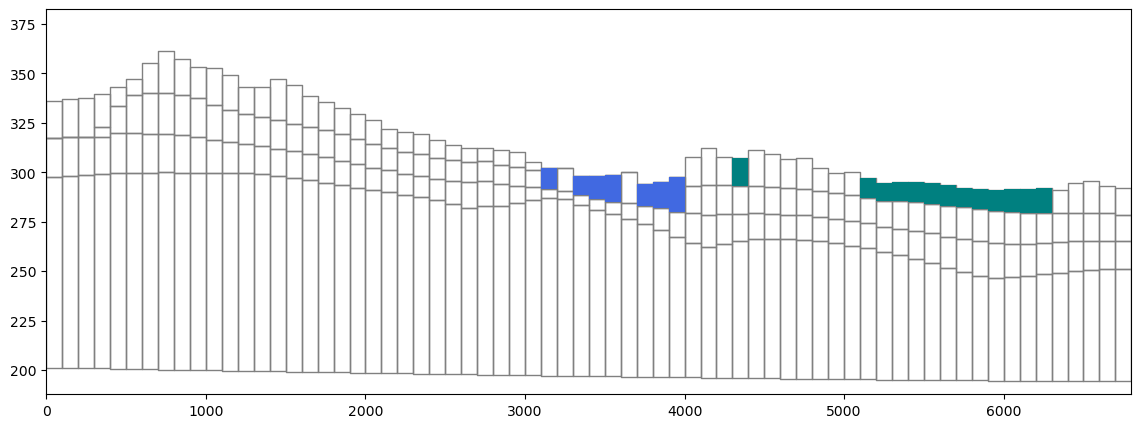

In [54]:
fig, ax = plt.subplots(figsize=(14, 5))
xs = flopy.plot.PlotCrossSection(model=m, line={"row": 30}, ax=ax)
lc = xs.plot_grid()
xs.plot_bc("LAK")
xs.plot_bc("SFR");

#### Along an arbitrary line
(and in Geographic Coordinates)

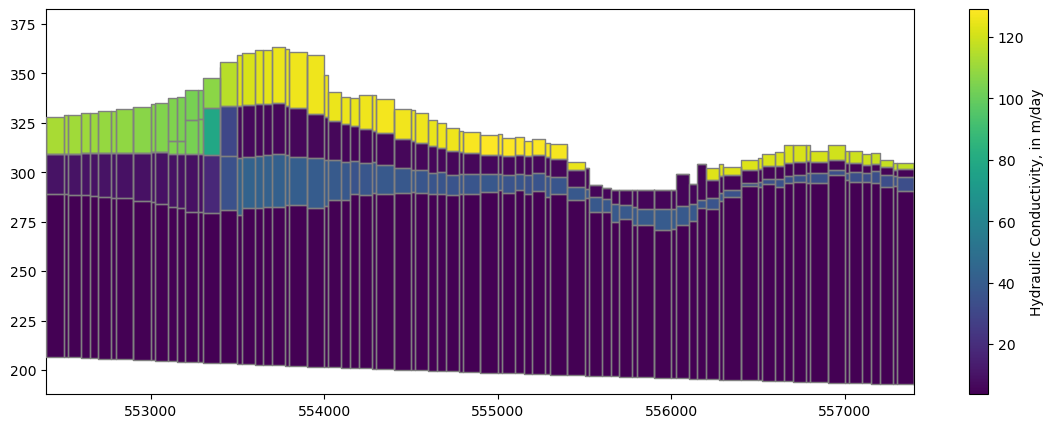

In [55]:
fig, ax = plt.subplots(figsize=(14, 5))
xs_line = [(552400, 393000), (552400 + 5000, 393000 - 4000)]
xs = flopy.plot.PlotCrossSection(model=m, 
                                 line={"line": xs_line}, ax=ax,
                                 geographic_coords=True)
lc = xs.plot_grid(zorder=4)

pc = xs.plot_array(m.npf.k.array)
fig.colorbar(pc, label='Hydraulic Conductivity, in m/day');


#### What if we want to look at cross sections for each row or column?
This code allows for every row or column to be visualized in cross section within the Jupyter Notebook session.

In [56]:
fig, ax = plt.subplots(figsize=(14, 5))
frames = m.modelgrid.shape[1] # set frames to number of rows

def update(i):
    ax.cla()
    xs = flopy.plot.PlotCrossSection(model=m, line={"row": i}, ax=ax)
    lc = xs.plot_grid()
    xs.plot_bc("LAK")
    xs.plot_bc("SFR")
    ax.set_title(f"row: {i}")
    return

import matplotlib.animation as animation
ani = animation.FuncAnimation(fig=fig, func=update, frames=frames)
plt.close()

from IPython.display import HTML
HTML(ani.to_jshtml())

### An aside on working with model input as numpy arrays
Every input to MODFOW is attached to a Flopy object (with the attribute name of the variable) as a numpy ``ndarray`` (for ndarray-type data) or a ``recarray`` for tabular or list-type data. For example, we can access the recharge array (4D-- nper x nlay x nrow x ncol) with:

```
m.rcha.recharge.array
```

#### ``ndarray`` example: plot spatial average recharge by stress period
To minimize extra typing, it often makes sense to reassign the numpy array to a new variable to work with it further.

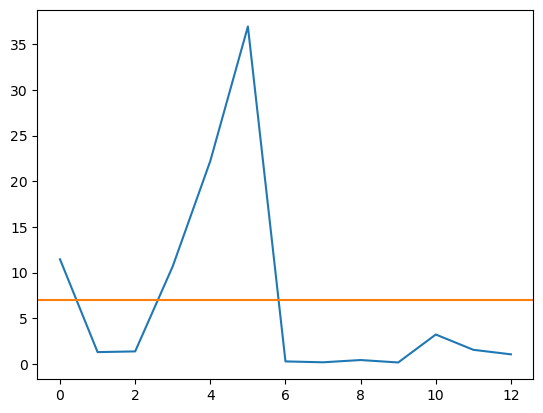

In [57]:
rch_inches = m.rcha.recharge.array[:, 0, :, :].mean(axis=(1, 2)) * 12 * 365.25 / .3048 
fig, ax = plt.subplots()
ax.plot(rch_inches)
ax.axhline(rch_inches.mean(), c='C1');

#### Tabular data example: plot pumping by stress period
Most tabular input for the 'basic' stress packages (Constant Head, Drain, General Head, RIV, WEL, etc) are accessable via a ``stress_period_data`` attribute.   
* To access the data, we have to call another ``.data`` attribute, which gives us a dictionary of ``recarray``s by stress period.  
* Any one of these can be converted to a ``pandas.DataFrame`` individually, or we can make a dataframe of all of them with a simple loop.

In [58]:
dfs = []
for kper, df in m.wel.stress_period_data.get_dataframe().items():
    df['per'] = kper
    dfs.append(df)
df = pd.concat(dfs)
df.head()

,layer,row,column,q,boundname,per
0,2,24,2,-396.867,pleasant_2-13-2,0
1,2,17,2,-409.900,pleasant_2-9-2,0
2,3,23,44,0.000,pleasant_3-12-23,0
3,3,25,26,0.000,pleasant_3-13-14,0
4,3,24,54,-878.654,pleasant_3-13-28,0


Now we can sum by stress period, or plot individual wells across stress periods

Text(0, 0.5, '$m^3$/day')

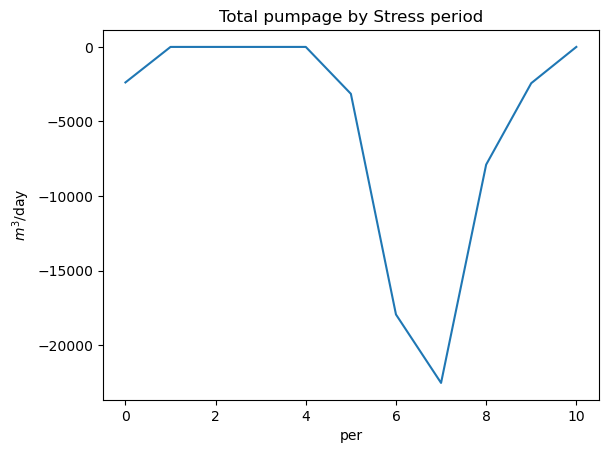

In [59]:
df.groupby('per').sum()['q'].plot()
plt.title('Total pumpage by Stress period')
plt.ylabel('$m^3$/day')

### Exercise: plot pumping for the well at cellid: 2, 24, 2
About many gallons did this well pump in stress periods 1 through 12?

## Visualizing model output

#### Run the model first to get the output

In [60]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../software/modflow_exes/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jun 28 2023 18:34:54 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor 

(True, [])

### Getting the output
With MODFLOW 6 models, we can get the output from the model object, without having to reference additional files. Sometimes though, it may be easier to read the file directly.

The head solution is reported for each layer. 
* We can use the ``get_water_table`` utility to get a 2D surface of the water table position in each cell. 
* To accurately portray the water table around the lake, we can read the lake stage from the observation file and assign it to the relevant cells in the water table array. 
* Otherwise, depending on how the lake is constructed, the lake area would be shown as a nodata/no-flow area, or as the heads in the groundwater system below the lakebed.
* In this case, we are getting the solution from the initial steady-state period

In [61]:
from flopy.utils.postprocessing import get_water_table

hds = m.output.head().get_data(kstpkper=(0, 0))
wt = get_water_table(hds)

# add the lake stage to the water table
lak_output = pd.read_csv(sim_ws / 'lake1.obs.csv')
stage = lak_output['STAGE'][0]
cnd = pd.DataFrame(m.lak.connectiondata.array)
k, i, j = zip(*cnd['cellid'])
wt[i, j] = stage

cbc = m.output.budget()
lak = cbc.get_data(text='lak', full3D=True)[0].sum(axis=0)
sfr = cbc.get_data(text='sfr', full3D=True)[0]

### Plot head and surface water flux results
We can add output to a PlotMapView instance as arrays

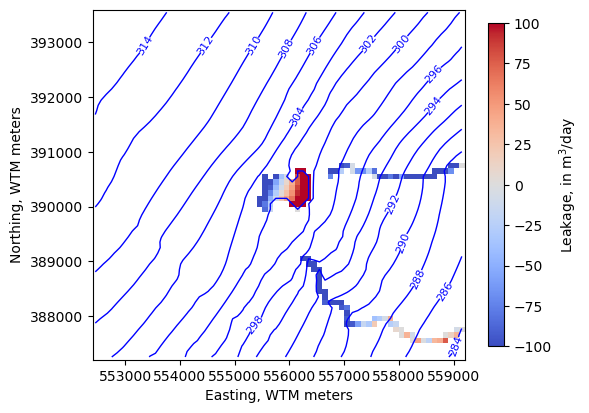

In [62]:
levels=np.arange(280, 315, 2)

fig, ax = plt.subplots(figsize=(6, 6))
pmv = flopy.plot.PlotMapView(m, ax=ax)
ctr = pmv.contour_array(wt, levels=levels, 
                        linewidths=1, colors='b')
labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=1)
vmin, vmax = -100, 100
im = pmv.plot_array(lak, cmap='coolwarm', vmin=vmin, vmax=vmax)
im = pmv.plot_array(sfr.sum(axis=0), cmap='coolwarm', vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, shrink=0.7, label='Leakage, in m$^3$/day')
ax.set_ylabel("Northing, WTM meters")
ax.set_xlabel("Easting, WTM meters")
ax.set_aspect(1)

#### Zoom in on the lake

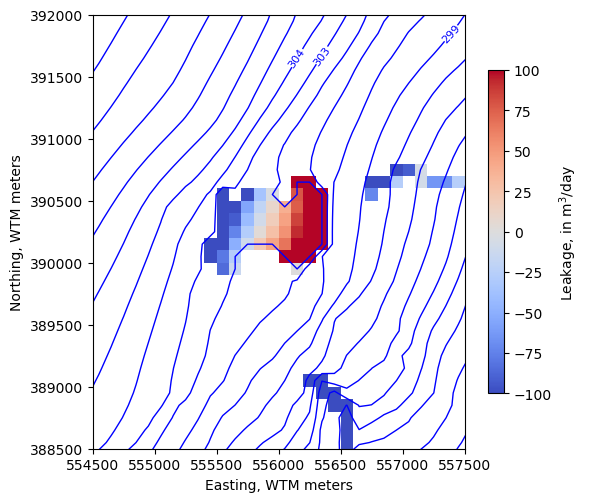

In [63]:
levels=np.arange(280, 315, 1)
new_extent = (554500, 557500, 388500, 392000)

fig, ax = plt.subplots(figsize=(6, 6))
pmv = flopy.plot.PlotMapView(m, ax=ax, extent=new_extent)
ctr = pmv.contour_array(wt, levels=levels, 
                        linewidths=1, colors='b')
labels = pmv.ax.clabel(ctr, inline=True, fontsize=8, inline_spacing=1)
vmin, vmax = -100, 100
im = pmv.plot_array(lak, cmap='coolwarm', vmin=vmin, vmax=vmax)
im = pmv.plot_array(sfr.sum(axis=0), cmap='coolwarm', vmin=vmin, vmax=vmax)
cb = fig.colorbar(im, shrink=0.7, label='Leakage, in m$^3$/day')
ax.set_ylabel("Northing, WTM meters")
ax.set_xlabel("Easting, WTM meters")
ax.set_aspect(1)

### Exporting Rasters
We can use the ``export_array`` utility to make a GeoTIFF of any 2D array on a structured grid. For example, make a raster of the simulated water table.

In [64]:
from flopy.export.utils import export_array

export_array(m.modelgrid, str(output_folder / 'water_table.tif'), wt)

/Users/aleaf/mambaforge/envs/pyclass/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


### Exercise: evaluating overpressurization
A common issue with groundwater flow models is overpressurization- where heads above the land surface are simulated. Sometimes, these indicate natural wetlands that aren't explicitly simulated in the model, but other times they are a sign of unrealistic parameters. Use the information in this lesson to answer the following questions:

1) Does this model solution have any overpressiuzation? If so, where? Is it appropriate?

2) What is the maximum value of overpressurization?

3) What is the maximum depth to water simulated? Where are the greatest depths to water? Do they look appropriate?

### Plot a cross section of the head solution with the water table
We can also view output in cross section. In this case, ``PlotMatView`` plots the head solution where the model is saturated. We can add the water table we created above that includes the lake surface.

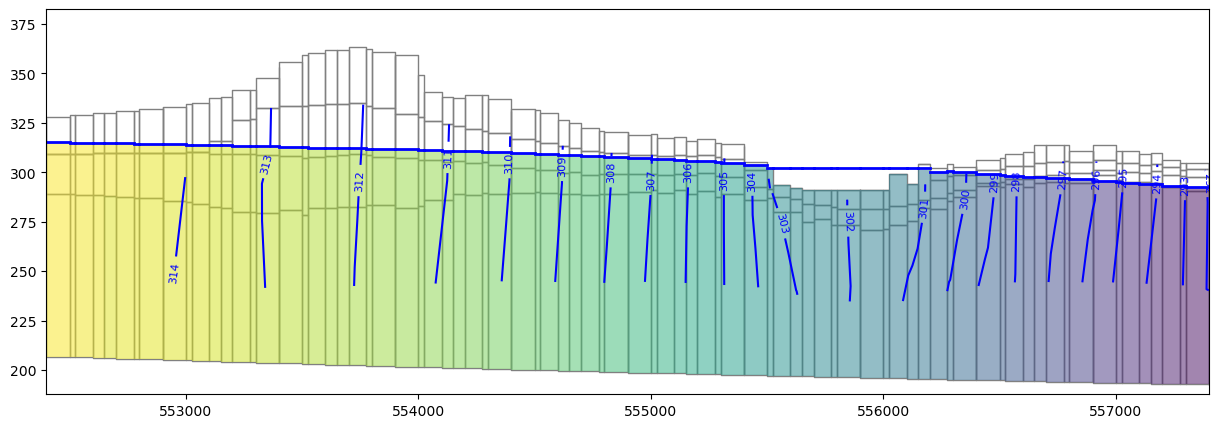

In [65]:
fig, ax = plt.subplots(figsize=(15, 5))
xs_line = [(552400, 393000), (552400 + 5000, 393000 - 4000)]
xs = flopy.plot.PlotCrossSection(model=m, 
                                 line={"line": xs_line}, 
                                 #line={"row": 32}, 
                                 ax=ax,
                                 geographic_coords=True)
lc = xs.plot_grid()
pc = xs.plot_array(hds, head=hds, alpha=0.5, masked_values=[1e30])
ctr = xs.contour_array(hds, head=hds, levels=levels, colors="b", masked_values=[1e30])
surf = xs.plot_surface(wt, masked_values=[1e30], color="blue", lw=2)

labels = pmv.ax.clabel(
    ctr, inline=True, 
    fontsize=8, inline_spacing=5)

## Getting observation output two ways
Above we obtained a DataFrame of output for pleasant lake by reading in the relevant file with pandas.
We can do this for heads too.

In [66]:
headobs = pd.read_csv(sim_ws / 'pleasant.head.obs')
headobs.head()

,time,00400037_UWSP,00400037_UWSP.1,00400037_UWSP.2,00400037_UWSP.3,00400041_UWSP,00400041_UWSP.1,00400041_UWSP.2,00400041_UWSP.3,10019264_LK,...,YH229.2,YH229.3,YQ987,YQ987.1,YQ987.2,YQ987.3,YS864,YS864.1,YS864.2,YS864.3
0,1.0,310.161509,310.152440,310.146632,309.972583,294.571188,294.533753,294.507520,294.460828,287.057064,...,301.671867,301.833545,302.314533,302.324774,302.335628,302.712518,312.448733,312.427510,312.400785,312.395162
1,32.0,310.114717,310.114717,310.108406,309.932164,294.496467,294.460880,294.436082,294.403306,287.002266,...,301.609129,301.772555,302.230838,302.244670,302.258673,302.652591,312.387007,312.383407,312.353905,312.348160
2,61.0,310.078745,310.078745,310.072239,309.894409,294.432037,294.396652,294.372019,294.340104,286.969376,...,301.559509,301.721138,302.179090,302.193726,302.208416,302.605806,312.345221,312.339465,312.307319,312.299521
3,92.0,310.051664,310.051664,310.048010,309.878756,294.459305,294.424027,294.399453,294.367593,287.008239,...,301.576502,301.736277,302.211276,302.221966,302.233239,302.614153,312.367330,312.340335,312.309477,312.304597
4,122.0,310.100468,310.085611,310.082751,309.915603,294.568056,294.532587,294.507949,294.476668,287.084117,...,301.647729,301.809016,302.261779,302.269823,302.278917,302.655915,312.416061,312.379106,312.355470,312.358140


Head observations can also be accessed via the ``.ouput`` attribute for their respective package. First we have to find the name associated with that package though. We can get this by calling ``get_package_list()``. Looks like ``"OBS_3"`` is it.

In [67]:
m.get_package_list()

['DIS',
 'IC',
 'NPF',
 'STO',
 'RCHA_0',
 'OC',
 'CHD_OBS',
 'CHD_0',
 'SFR_OBS',
 'SFR_0',
 'LAK_OBS',
 'LAK_LAKTAB',
 'LAK_0',
 'WEL_0',
 'OBS_3']

In [68]:
#m.obs_3.output.obs()

### Using boundnames to define observations
In MODFLOW 6, we can use boundnames to create observations for groups of cells. For example, in this model, each head value specified in the Constant Head Package has a ``boundname`` of east, west, north or south, to indicate the side of the model perimeter it's on. The Constant Head Observation Utility input is then set up like so:
```
BEGIN options
END options

BEGIN continuous  FILEOUT  pleasant.chd.obs.output.csv
# obsname obstype ID
  east  chd  east
  west  chd  west
  north  chd  north
  south  chd  south
END continuous  FILEOUT  pleasant.chd.obs.output.csv
```

The resulting observation output can be found in ``pleasant.chd.obs.output.csv``

In [69]:
df = pd.read_csv(sim_ws / 'pleasant.chd.obs.output.csv')
df.index = df['time']
df.head()

,time,EAST,WEST,NORTH,SOUTH
time,,,,,
1.0,1.0,-34777.280407,6212.364587,17421.976405,-9693.429003
32.0,32.0,-34508.241761,6363.316750,17572.839997,-9487.079654
61.0,61.0,-34204.575946,6300.560999,17485.626670,-9557.938536
92.0,92.0,-34234.775964,5908.645868,17351.380660,-9853.127093
122.0,122.0,-34721.889213,5359.082084,17203.878073,-10100.990732


## Plotting global mass balance from the listing file
The ``Mf6ListBudget`` and ``MfListBudget`` (for earlier MODFLOW versions) utilities can assemble the global mass balance output (printed in the Listing file) into a DataFrame. A ``start_datetime`` can be added to convert the MODFLOW time to actual dates.

**Note:** The ``start_datetime`` functionality is unaware of steady-state periods, so if we put in the actual model start date of 2012-01-01, the 1-day initial steady-state will be included, resulting in the stress periods being offset by one day. Also note that the dates here represent the *end* of each stress period.

In [70]:
from flopy.utils import Mf6ListBudget 

In [71]:
mfl = Mf6ListBudget(sim_ws / 'pleasant.list')
flux, vol = mfl.get_dataframes(start_datetime='2011-12-30')
flux.head()

,STO-SS_IN,STO-SY_IN,WEL_IN,RCHA_IN,CHD_IN,SFR_IN,LAK_IN,TOTAL_IN,STO-SS_OUT,STO-SY_OUT,WEL_OUT,RCHA_OUT,CHD_OUT,SFR_OUT,LAK_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
2011-12-31,0.0000,0.000000,0.0,33188.867188,23435.904297,349.638306,3680.284180,60654.695312,0.000000,0.000000,2383.022705,0.0,44272.273438,11781.069336,2217.934814,60654.296875,0.396000,0.0
2012-01-31,6.7081,25877.734375,0.0,3485.810791,23184.136719,518.563782,3719.994385,56792.949219,0.241800,156.215195,0.000000,0.0,43243.300781,11221.008789,2172.376465,56793.144531,-0.195200,-0.0
2012-02-29,6.5506,24792.722656,0.0,3771.585449,23037.080078,680.194580,3735.312012,56023.445312,0.001131,20.584900,0.000000,0.0,43013.406250,10831.583008,2157.964844,56023.539062,-0.094266,-0.0
2012-03-31,0.5149,3190.234619,0.0,30861.951172,23084.673828,687.003601,3648.997559,61473.375000,1.263200,4260.674316,0.000000,0.0,43912.550781,11090.963867,2208.054443,61473.503906,-0.129200,-0.0
2012-04-30,0.0000,0.000000,0.0,64854.593750,22838.197266,377.562012,3493.942871,91564.296875,9.284800,32114.669922,0.000000,0.0,45098.117188,12015.685547,2326.493896,91564.250000,0.044994,0.0


In [72]:
flux.columns

Index(['STO-SS_IN', 'STO-SY_IN', 'WEL_IN', 'RCHA_IN', 'CHD_IN', 'SFR_IN',
       'LAK_IN', 'TOTAL_IN', 'STO-SS_OUT', 'STO-SY_OUT', 'WEL_OUT', 'RCHA_OUT',
       'CHD_OUT', 'SFR_OUT', 'LAK_OUT', 'TOTAL_OUT', 'IN-OUT',
       'PERCENT_DISCREPANCY'],
      dtype='object')

### Check the model mass balance error

<Axes: >

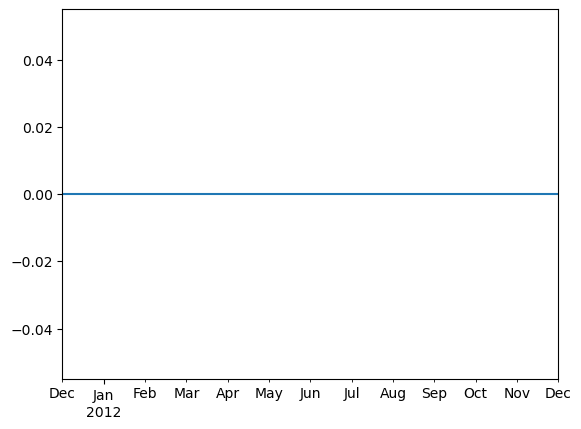

In [73]:
flux['PERCENT_DISCREPANCY'].plot()

### Make a stacked bar plot of the global mass balance

Note: This works best if the in and out columns are aligned, such that ``STO-SY_IN`` and ``STO-SY_OUT`` are both colored orange, for example.

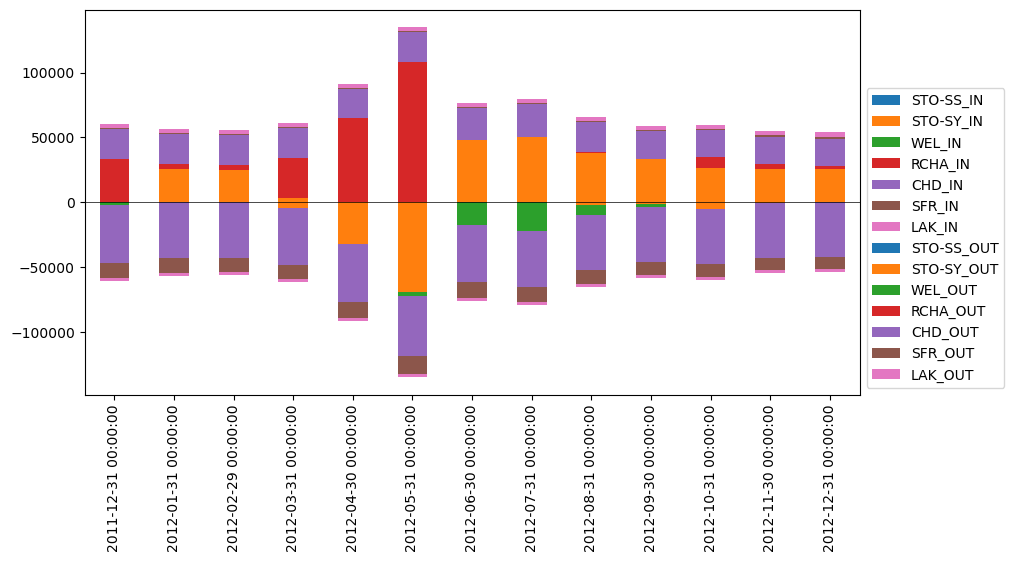

In [74]:
fig, ax = plt.subplots(figsize=(10, 5))
in_cols = ['STO-SS_IN', 'STO-SY_IN', 'WEL_IN', 'RCHA_IN', 'CHD_IN', 'SFR_IN', 'LAK_IN']
out_cols = [c.replace('_IN', '_OUT') for c in in_cols]
flux[in_cols].plot.bar(stacked=True, ax=ax)
(-flux[out_cols]).plot.bar(stacked=True, ax=ax)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0))
ax.axhline(0, lw=0.5, c='k')

### References

Fienen, M. N., Haserodt, M. J., Leaf, A. T., and Westenbroek, S. M. (2022). Simulation of regional groundwater flow and groundwater/lake interactions in the central Sands, Wisconsin. U.S. Geological Survey Scientific Investigations Report 2022-5046. doi:10.3133/sir20225046

Fienen, M. N., Haserodt, M. J., and Leaf, A. T. (2021). MODFLOW models used to simulate groundwater flow in the Wisconsin Central Sands Study Area, 2012-2018. New York: U.S. Geological Survey Data Release. doi:10.5066/P9BVFSGJ